# 2025 Spring ORF307 Final Project Solutions

Instructor: B. Stellato

AIs: Yanjun Liu, Qishuo Yin, Chenyu Yu, and Kaiwen Zhang

___

## Instructions
**Exam files:** the exam files are available to download at [THIS LINK.](https://www.dropbox.com/scl/fo/b6an98pypucpvdhb81osz/AHSPIHMuLOtnttr-CDG6ZZY?rlkey=6wph0csyr9gldp2lo7akkx4ln&st=ckxp1xua&dl=0)

**Date and time:** From May 8, 2025 at 00:01am to May 11, 2025 at 7:00pm.

- Total time after download: 24 hours. No late submissions allowed. Note that the deadline is either 24 hours after download, or May 11, 2025 at 7:00pm, **whichever comes first**.

## Exam Rules
- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you **cannot use internet to search for answers**.
- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.
- You cannot communicate with anyone during the exam.
- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.
- The exam is to be submitted electronically on Gradescope before 7:00pm on the final day.

# Final Exam

## Introduction 

For this final project, you will work with the Fashion MNIST dataset including thousands of images of clothes, which we have provided in CSV format. 

You will work with a pre-processed version of this dataset where each label is +1 if the image is a shirt and -1 otherwise.

To load the dataset, ensure the following files are in a folder called `data/` in your working directory: `X_train.csv`, `y_train.csv`, `X_test.csv`, `y_test.csv`. Then run the following code to import the packages and load the data

In [1]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv(f"data/X_train.csv").values
y_train = pd.read_csv(f"data/y_train.csv").values.ravel()
X_test = pd.read_csv(f"data/X_test.csv").values
y_test = pd.read_csv(f"data/y_test.csv").values.ravel()

n_train, m = X_train.shape
n_test, m = X_test.shape

print("-" * 50)
print("Fashion MNIST dataset")
print("-" * 50)
print(f"Number of features: {m}  ({int(np.sqrt(m))} x {int(np.sqrt(m))} pixels)")
print(f"Training set:")
print(f"  • Samples: {n_train}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Test set:")
print(f"  • Samples: {n_test}")
print(f"  • Value range: [{X_train.min():.2f}, {X_train.max():.2f}]")

--------------------------------------------------
Fashion MNIST dataset
--------------------------------------------------
Number of features: 784  (28 x 28 pixels)
Training set:
  • Samples: 5000
  • Value range: [0.00, 255.00]
Test set:
  • Samples: 1000
  • Value range: [0.00, 255.00]


Now, let's visualize a couple of images

In [3]:
def visualize_images(*images):
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(14,6))
    if n_images == 1:
        axes = [axes]   
    for i, (ax, img) in enumerate(zip(axes, images)):
        img_reshaped = img.reshape(28, 28)
        im = ax.imshow(img_reshaped, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

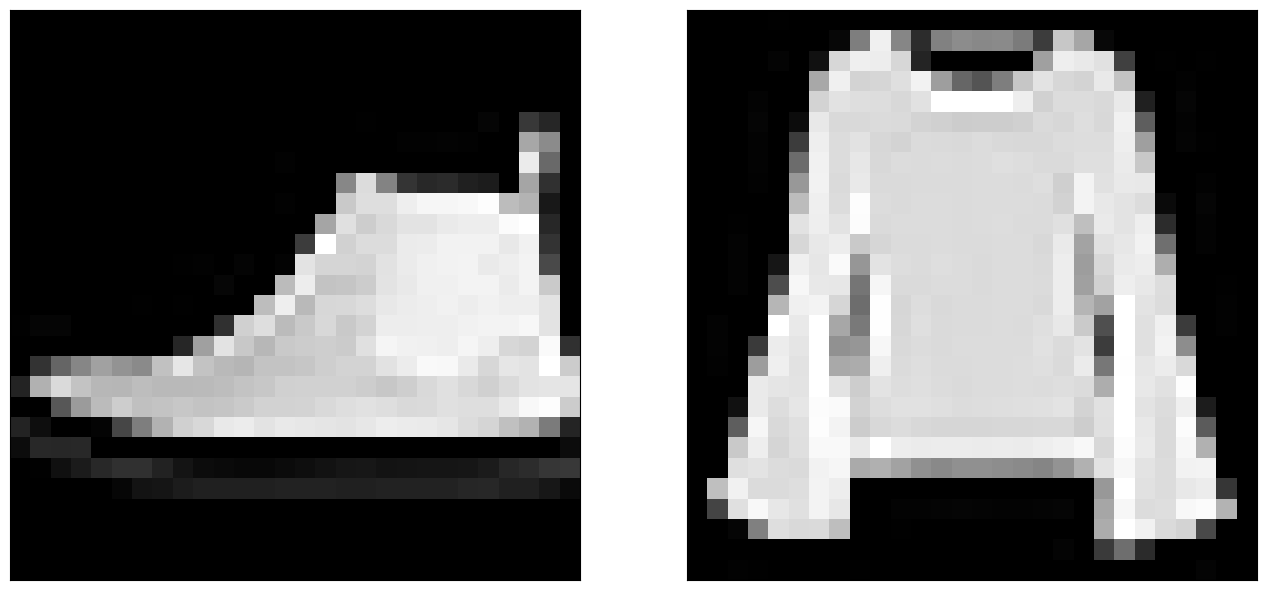

In [4]:
example_boot = X_train[3]
example_shirt = X_train[0]
visualize_images(example_boot, example_shirt)

# 1. (35 points) Build a Support Vector Machine to correctly classify shirts

1. (5 points) Formulate a Support Vector Machine problem to find a hyperplane $(a, b)$ where $a \in \mathbf{R}^m$ and $b \in \mathbf{R}$ to classify shirts. Given sample $x^{(i)}$, your hyperplane should be $a^Tx^{(i)} + b > 0$ if label $y^{(i)} = 1$ (shirt) or $a^Tx^{(i)} + b < 0$ if label $y^{(i)} = -1$ (not a shirt). You should include a second term in the objective, weighted by parameters $\lambda > 0$ to regularize the $\ell_1$-norm of $a$.

    Note: Remember to normalize the misclassification error by the total number of training samples.

**solution**
\begin{equation}
		\begin{array}{ll}
			\text{minimize} & \frac{1}{n_{train}}\sum_{i = 1}^{n_{train}} \max(0, 1 - y^{(i)}(a^T x^{(i)} + b)) + \lambda \Vert a \Vert_1
		\end{array}
	\end{equation}

2. (8 points) Run a cross-validation procedure: solve the problem using CVXPY and CLARABEL solver for $\lambda = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05)$ and pick the model that has the lowest test error.

    Note, these problems are quite large so it may take a few seconds to solve them. (you may use the argument `verbose=True` to print out the solver progress).

    Here is a utility function to check the test error. For example, you can use it as `error(X_test, y_test, a, b)`

In [5]:
def error(X, y, a, b):
    y_pred = np.sign(X @ a + b)
    return np.mean(y_pred != y)

In [6]:
#SOLUTION:
val = []
vala = []
valb = []
lmbds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
a = cp.Variable(m)
b = cp.Variable(1)
lmbd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(cp.sum(cp.maximum(0, 1 - cp.multiply(y_train,  (X_train @ a + b * np.ones(n_train)))))/n_train + lmbd * cp.norm(a, 1)))
for lmbd_val in lmbds:
    lmbd.value = lmbd_val
    print("lambda: ", lmbd_val)
    prob.solve(solver = cp.CLARABEL, verbose = False)
    val = val + [prob.value]
    vala = vala + [a.value]
    valb = valb + [b.value]

lambda:  0.0001
lambda:  0.0005
lambda:  0.001
lambda:  0.005
lambda:  0.01
lambda:  0.05


In [7]:
opti = 0
opterr = error(X_test, y_test, vala[0], valb[0])
for i in range(1, 6):
    if error(X_test, y_test, vala[i], valb[i]) < opterr:
        opti = i
        opterr = error(X_test, y_test, vala[i], valb[i])
print("optimal lambda:")
print(lmbds[opti])
best_lambda = lmbds[opti]

optimal lambda:
0.05


3. (7 points) Write the training problem as a linear program in inequality form (get rid of all norms and maxima in the formulation)

**solution**

\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \frac{1}{{n_{train}}} v^T \mathbf{1}_{n_{train}} + \lambda u^T \mathbf{1}_m\\
		\text{subject to} & u \geq a\\
        & u \geq -a\\
        & v_i \geq 1 - y^{(i)}(a^T x^{(i)} + b)\\
        & v \geq 0\\
        & a \in \mathbf{R}^m, b\in \mathbf{R}, u \in \mathbf{R}^m, v \in \mathbf{R}^{n_{train}}
	\end{array}
\end{equation}

where $\mathbf{1}_k$ denote the vector of ones in $\mathbf{R}^k$. We can also write it into matrix form. For that, we define $D_y \in \mathbf{R}^{n_{train} \times n_{train}}$ as the diagonal matrix with the diagonal entries $y^{(i)}$. Further, we consider $X\in \mathbf{R}^{n_{train} \times m}$ as the matrix with the $x^{(i)}$ as rows. Then, we can rewrite the problem as

\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \frac{1}{{n_{train}}} v^T \mathbf{1}_{n_{train}} + \lambda u^T \mathbf{1}_m\\
		\text{subject to} & -a + u \geq 0\\
        & a + u \geq 0\\
        & D_y X a + b y + v \geq \mathbf{1}_{n_{train}}\\
        & v \geq 0\\
        & a \in \mathbf{R}^m, b\in \mathbf{R}, u \in \mathbf{R}^m, v \in \mathbf{R}^{n_{train}}
	\end{array}
\end{equation}

4. (10 points) Write the dual problem in standard form. Solve it and find the optimal dual variables for $\lambda = 0.025$.

**solution**

\begin{equation}
	\begin{array}{ll}
		\text{maximize} & \frac{1}{{n_{train}}}^T t \\
		\text{subject to} & -r + s + X^TD_y^Tt = 0\\
        & y^T t = 0\\
        & r + s = \lambda \mathbf{1}_m\\
        & t + w = \frac{1}{n_{train}} \mathbf{1}_{n_{train}}\\
        & r \ge 0, s \ge 0, t \ge 0, w \ge 0
	\end{array}
\end{equation}

In [8]:
Dy = np.diag((y_train))
Dx = Dy @ X_train

In [9]:
r = cp.Variable(m)
s = cp.Variable(m)
t = cp.Variable(n_train)
w = cp.Variable(n_train)
dprob = cp.Problem(cp.Maximize(np.ones(n_train).T @ t), 
                   [-r + s + Dx.T @ t == 0, y_train.T @ t == 0, 
                    r + s == 0.025 * np.ones(m), 
                    t + w == np.ones(n_train)/n_train, 
                    r >= 0, s >= 0, t >= 0, w >= 0])
dprob.solve(solver=cp.CLARABEL)
dualval = np.concatenate((r.value, s.value, t.value, w.value), axis = None)

5. (10 points) As you noticed, solving this problem can be expensive, but you still would like to carefully tune the parameter $\lambda$. To avoid unnecessary computations, you would like to understand if, when you vary $\lambda$ within the interval $[0.025, 0.05]$, the optimal $a$ and $b$ for your SVM would change or not. To check this, you would like to use the optimal dual variables you have found in the previous problem. Using complementary slackness, verify whether the optimal solution for the SVM for $\lambda = 0.05$ and the optimal dual variables you have found for $\lambda = 0.025$ can form an optimal primal-dual pair. From this, what would you expect for the optimal $a$ and $b$ for  $\lambda \in [0.025, 0.05]$? Do you need to try out the values of $\lambda$ in that interval or not?

    *Hint: To check for non zero entries, remember to allow for a small tolerance to account for numerical errors. You can use`1e-05`.*

**solution**

From the code below, we can conclude that complementary slackness does not hold. Therefore, the optimal dual variables for $\lambda = 0.025$ and the previous found solution to the SVM cannot form an optimal primal-dual pair. We thus expect the optimal $a$ and $b$ to vary within the interval $\lambda \in [0.025, 0.05]$.

In [10]:
C = np.concatenate((-vala[5] + np.abs(vala[5]), 
                    vala[5] + np.abs(vala[5]), 
                    Dx @ vala[5] + valb[5] * y_train + np.maximum(0, 1 - Dx @ vala[5] - valb[5] * y_train) - 1, 
                    np.maximum(0, 1 - Dx @ vala[5] - valb[5] * y_train)), axis = None)
I = (np.multiply(C, dualval) > 1e-5)
print(np.count_nonzero(I))

140


# (25 points) computing adversarial examples

We now would like to verify the robustness of our classifier by looking at adversarial examples. To do so, we will consider all images close to a *representative image* and see if appropriate pixel perturbations could confuse our classifier.

1. (10 points) Formulate the problem of finding the closest image, in terms of the $\ell_1$-norm, to the shirt one at index `example_shirt = 0`, that gets misclassified.

    Note: images have pixel intensities between 0 and 255.

**solution**
Our objective is to minimize $\ell_1$ distance to $x_{\text{example}}$, such that $a^T x + b \leq 0$ (not classified as a shirt). 

$$ \begin{array}{ll@{}l}
\text{minimize} & \|x - x_{\text{example}}\|_1 & \\
\text{subject to} & a^T x + b \leq 0 & \text{(misclassification constraint)} \\
& 0 \leq x \leq 255.
\end{array} $$



2. (5 points) Formulate the problem as a linear program in inequality form without including any norm.

**solution**
$$ \begin{array}{ll}
\text{maximize} & \sum_j t_j \\
\text{subject to } & a^Tx + b \leq 0 \\
& t_j \geq x_j - x_{\rm example, j} \quad \forall j \\
& t_j \geq x_{\rm example, j} - x_j \quad \forall j \\
& 0 \leq x \leq 255
\end{array} $$

3. (10 points) Solve problem compare the resulting image with the example shirt above. How many pixels are modified? What is the $\ell_1$-norm distance between the images? Plot the images side by side using the `visualize_images` function above and describe what's different.

    Note: to count which pixels are modified, use a tolerance of `1e-05` to account for small numerical errors.

the number of pixle modified is: 1
the l1 distance between advserial example and example shirt is  91.18


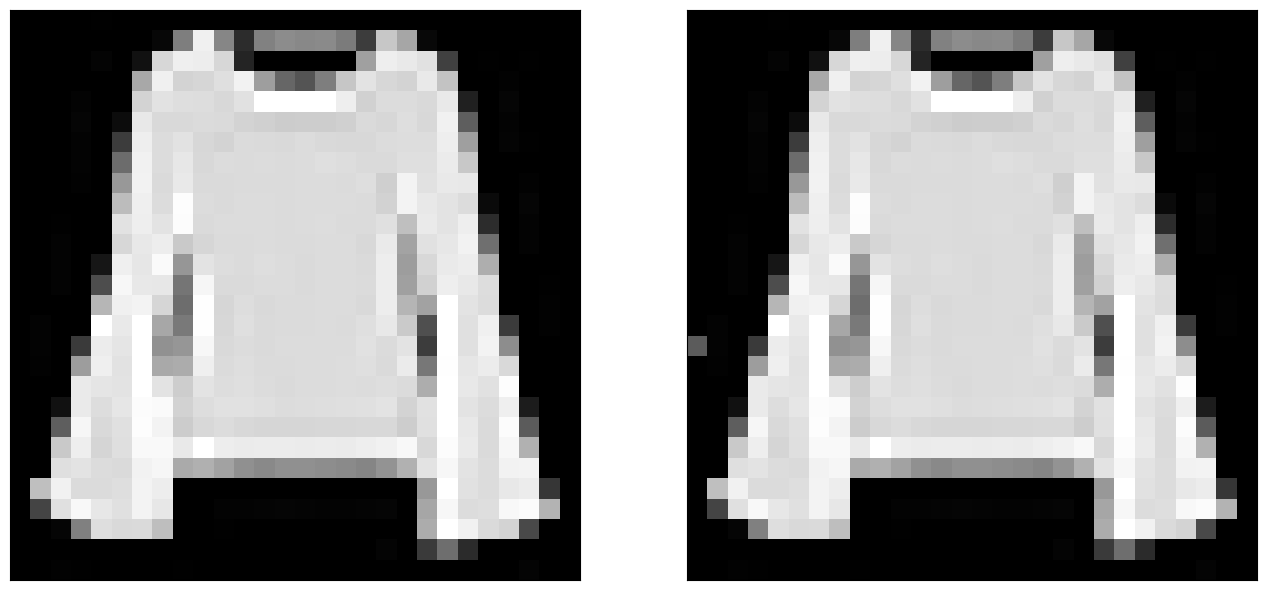

In [11]:
def find_misclassified_lp(x_example, a, b):
    m = len(x_example)
    x = cp.Variable(m)
    t = cp.Variable(m)
    
    objective = cp.Minimize(cp.sum(t))
    constraints = [
        a.T @ x + b <= 0, # not a tshirt
        x - x_example <= t,                
        x_example - x <= t,                 
        0 <= x, x <= 255,
        t >= 0
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL)
    
    if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        raise ValueError(f"Optimization failed with status: {problem.status}")
    
    return x.value

a = vala[i]
b = valb[i]
adv_example = find_misclassified_lp(example_shirt, a, b)
n_modified = np.sum(np.abs(adv_example - example_shirt) > 1e-05)
print(f"the number of pixle modified is: {n_modified}")
l1_distance = np.linalg.norm(adv_example - example_shirt, 1)
print(f"the l1 distance between advserial example and example shirt is {l1_distance: .2f}")
visualize_images(example_shirt, adv_example)

You can see that the resulting image looks like a shirt, and, because of the only modified pixel, it gets classified as not a shirt.

# (35 points) Production planning with quality control via SVM
You are a clothing manufacturer that produces a certain amount of shirts (`n_shirts`) daily but can only inpsect 40% of them due to resource constraints. Your excellent shirt classifier from part 1 wil turn out to be helpful to decide which ones to inspect. The company incurs in various costs:

- Inspection cost: $c = 10$ per item inspected
- False negative (error) cost: $d = 20$ per defective item that reaches a customer (which will not be happy about the purchase)
- True positive (correct) cost (savings): $s = 15$ from catching a defective item before shipping

For each shirt $i$, you need to decide whether to inspect it using binary variable $w_i \in \{0, 1\}$. We will use the trained SVM problem to suggest to inspect the item if it is not classified as a shirt. Specifically, we transform the output of the SVM into a probability with values between $0$ and $1$ using the following function. For an image $i$, the probability of the product to be defective (i.e., not a shirt) is 
$$p^{(i)} = \sigma(- (a^Tx^{(i)} + b)),$$
where $\sigma(x) = 1 / (1 + \exp(-x))$ is the sigmoid function.

1. (5 points) Calculate the predicted probabilities for all training shirt images. Use the `X_shirt` images data defined here for convenience.

In [12]:
# get shirt training and testing datasets
shirt_indices_train = np.where(y_train == 1)[0]
X_shirt_train = X_train[shirt_indices_train]
n_shirt_train = X_shirt_train.shape[0]
inspection_capacity_train = int(0.4 * n_shirt_train)

shirt_indices_test = np.where(y_test == 1)[0]
X_shirt_test = X_test[shirt_indices_test]
n_shirt_test = X_shirt_test.shape[0]
inspection_capacity_test = int(0.4 * n_shirt_test)

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prob(X, a, b):
    return sigmoid(- (X @ a + b))

prob_train = prob(X_shirt_train, a, b)

2. (5 points) Run a naive approach. Inspect the items with the largest probability of being defective. Visualize the top-3 items

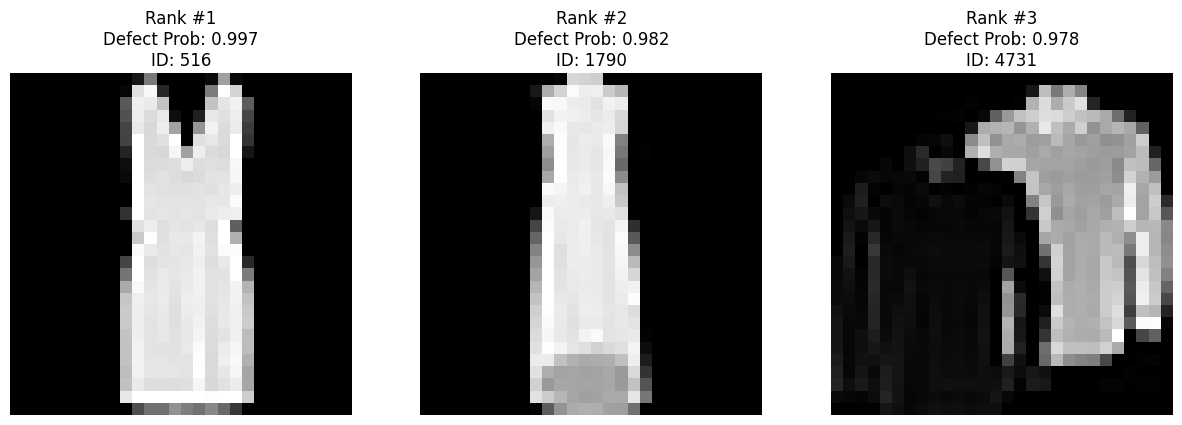

In [14]:
indices_naive_train = np.argsort(prob_train)[::-1][:inspection_capacity_train] 
top_indices = indices_naive_train[:3]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_indices):
    shirt_image = X_shirt_train[idx].reshape(28, 28)
    plt.subplot(1, 3, i+1)
    plt.imshow(shirt_image, cmap='gray')
    plt.title(f"Rank #{i+1}\nDefect Prob: {prob_train[idx]:.3f}\nID: {shirt_indices_train[idx]}")
    plt.axis('off')

3. (10 points) Define a mixed-integer optimization problem to minimize the expected cost, i.e., the sum of all the components of the objective, weighted by the defective probabilities. Ensure that the number of inspected products is less than `inspection_capacity`.

**Solution**
Let's split the cost in a deterministic and expected part. The deterministic one is $\omega_i c$ where $\omega_i = 1$ if product $i$ is inspected, or $0$ otherwise. 
The expected part is the sum of $(1-\omega_i)  d - \omega_i s$ weighted by probabilities $p^{(i)}$.
Therefore, we can formulate the mixed-integer problem below: 
$$
\begin{array}{ll}
    \text{minimize} & \sum_{i=1}^{\rm n\_ shirt} \omega_i c + p^{(i)} ((1-\omega_i)  d - \omega_i s) \\
    \text{subject to} & \sum_{i=1}^{\rm n\_ shirt} \omega_i \leq \texttt{inspection\_capacity}\\
    & \omega_i \in \{0, 1\}
\end{array}
$$

4. (15 points) Solve the problem for both training and testing datasets, and compare the expected cost with the naive approach. You can use cvxpy solver `SCIPY` (which internally calls the HIGHS MIP solver). Which approach is better? Why?

In [15]:
c=10
d=20
s=15
def compute_expected_cost(w, p):
    return 1/len(w) * np.sum(w * c + p * ( (1 - w) * d - w * s))

# Solve MIP
def MIP(X, prob_X):
    n_shirt = X.shape[0]
    inspection_capacity = int(0.4 * n_shirt)
    w = cp.Variable(n_shirt, boolean=True)
    # expected_cost = cp.sum(d*prob_X + cp.multiply(w, c - (s + d) * prob_X))
    expected_cost = cp.sum(cp.multiply(w, c) + cp.multiply(prob_X, (1 - w) * d - w * s))
    objective = cp.Minimize(expected_cost)
    constraints = [cp.sum(w) <= inspection_capacity]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIPY)
    return w.value

### Train data
n_shirt_train = X_shirt_train.shape[0]
prob_train = prob(X_shirt_train, a, b)
# Naive approach
w_naive_train = np.zeros(n_shirt_train)
w_naive_train[indices_naive_train] = 1
cost_naive_train = compute_expected_cost(w_naive_train, prob_train)
print("Trained cost by naive approach: ", cost_naive_train)
# MIP approach
w_MIP_train = MIP(X_shirt_train, prob_train)
cost_MIP_train = compute_expected_cost(w_MIP_train, prob_train)
print("Trained cost by MIP approach: ", cost_MIP_train)

### Test data
shirt_indices_test = np.where(y_test == 1)[0]
prob_test = prob(X_shirt_test, a, b)
# Naive approach
w_naive_test = np.zeros(n_shirt_test)
indices_naive_test = np.argsort(prob_test)[::-1][:inspection_capacity_test] 
w_naive_test[indices_naive_test] = 1
cost_naive_test = compute_expected_cost(w_naive_test, prob_test)
print("Test cost by naive approach: ", cost_naive_test)
# MIP approach
w_MIP_test = MIP(X_shirt_test, prob_test)
cost_MIP_test = compute_expected_cost(w_MIP_test, prob_test)
print("Test cost by MIP approach: ", cost_MIP_test)

Trained cost by naive approach:  3.1405496316452837
Trained cost by MIP approach:  2.9929953273799703
Test cost by naive approach:  2.690825604003194
Test cost by MIP approach:  2.657516289839846
